In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import scipy

In [14]:
marker_to_behavior = {
    "chr1:42445143": ['2','4', '5', '6', '8', '11', '13', '108', '228',  "factor_2"],
    "chr10:8354804": ['41', '107', '109', 'factor_8', '37', '41', '82', '83', '88', '166'],
    "chr10:8415970": ['41', '107', '109', 'factor_8'],
    "chr10:8752420": ['41', '107', '109', 'factor_8'],
    "chr10:8808920": ['71', '73', '75', 'factor_6', '41', '107', '109', 'factor_8'],
    "chr10:2790081": ['11', '42', '46', '167', '170', '171', '175', '37', '41', '82', '83', '88', '166', '71', '73', '75', 'factor_6'],
    "chr15:41524634": ['37', '41', '82', '83', '88', '166'],
    "chr15:41543072": ['37', '41', '82', '83', '88', '166'],
    "chr18:20591145": ['74', '75', '77', "factor_6", '37', '41', '82', '83', '88', '166', '21', '23', '31', '34', '53', '57', '11', '42', '46', '167', '170', '171', '175'],
    "chr34:18730331": ['74', '75', '77', "factor_6", '41', '107', '109', 'factor_8'],
#    "chrX:103473176" : ['74', '75', '77', "factor_6"],
#    "chrX:104047776" : ['74', '75', '77', "factor_6"],
}

maclean = pd.read_csv("/seq/vgb/bryc/projects/dog_behavioral_gwas_paper/data/Maclean_sig_SNPs.csv", header=None)
marker_to_behavior.update(dict(zip(maclean[0], maclean[1].str.split(','))))

marker_to_morphology = {
    "chr1:42445143": ['246'],
    "chr34:18730331": ['121'],
    "chr10:8354804": ['125', '121'],
    "chr10:8415970": ['125', '121'],
    "chr10:8752420": ['125', '121'],
    "chr10:8808920": ['125', '121'],
    "chr10:2790081":['121', '125'],
    "chr10:8354804":['121', '125'],
    "chr15:41543072": ['121'],
    "chr18:20591145": ['121', '246'],
    #"chr12:57877660": ['122'],
    ##"chr11:33520295": ['122'],
    #"chr12:60476684": ['122'],
    "chr32:33275351": ['127']
    
}

all_sites = set(list(marker_to_morphology.keys()) + list(marker_to_behavior.keys()))

In [15]:
height_file="/seq/vgb/vsohrab/darwins_dogs/pnas_behavior_morphology_gwas/input_files/DarwinsArk_AgeComposed_Height_N-3277.tsv"
neuter_file="/seq/vgb/vsohrab/darwins_dogs/pnas_behavior_morphology_gwas/input_files/DarwinsArk_Sex_NeuterStatus_N-3277.tsv"
pheno_file="/seq/vgb/bryc/data/darwins_dogs/2024-09-23_cache/2024-10-15_merged_phenotype_table.csv"
geno_file="/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/target_sites_genotypes.csv"

In [16]:
# Load dataframes
ph = pd.read_csv(pheno_file)
genos = pd.read_csv(geno_file)
height = pd.read_csv(height_file, sep = "\t",header=None, names = ["fam_id", "dog", "age", "height"])
neuter = pd.read_csv(neuter_file, sep = "\t", header=None, names = ["fam_id", "dog", "sex", "neuter"])

/local/scratch/47358729.1.interactive/ipykernel_64436/2982985312.py:2: DtypeWarning: Columns (15,259,260) have mixed types. Specify dtype option on import or set low_memory=False.
  ph = pd.read_csv(pheno_file)


In [17]:
merge = ph.merge(genos, left_on='id', right_on='dog')
merge2 = merge.merge(height, left_on='id', right_on="dog")
merge2.columns = merge2.columns.str.replace(' ', '_')
merge2['sex'] = merge2.sex.replace({'male': 0, 'female':1})

In [18]:
# Make mixed breed dog dataframe
PUREBRED_CUTOFF = 0.85

breeds = merge2.columns[19:131]
purebred_dogs = merge2.id[merge2.purebred == "yes"].to_list()
for breed in breeds:
    purebreds_breed = merge2.id[merge2[breed] > PUREBRED_CUTOFF].to_list()
    if len(purebreds_breed) > 0:
        purebred_dogs.extend(purebreds_breed)
mixed = merge2[~merge2.id.isin(purebred_dogs)].copy()

In [19]:
mixed['122']

0             1
1             0
3             8
5       0|2|4|5
6         1|2|5
         ...   
3271        NaN
3273        0|5
3274        NaN
3275        NaN
3276          4
Name: 122, Length: 2454, dtype: object

# Run likelihoods test for  dogs

In [20]:
# Clear outfile:
with open('/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/full_vs_reduced_LRTs.csv', 'w'):
    print("")

def run_likelihood_tests(snp_dict, df, size_covariates = True, ancestries = None, ancestry_dict = None):   
    results = []
    with open('/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/full_vs_reduced_LRTs.csv', 'a') as fh:
        for snp in snp_dict.keys():    
            if ancestry_dict is not None:
                ancestries = ancestry_dict[snp]
            if ancestries is not None:
                ancestries_cov = " + " + " + ".join(ancestries)
            else:
                ancestries_cov = ""
            for pheno in snp_dict[snp]:
                print(f"Running snp {snp}, pheno {pheno}")
                # OLS is _very_ finicky about column names so we will copy ours over to "clean" names here
                df['test_snp'] = df[snp]
                df['phenotype'] = df[pheno]
                df['leg_length'] = df['246']
                if size_covariates == False:
                    formula_text = 'phenotype ~ age_y + C(sex) + C(neutered)  + test_snp'
                    reduced_formula_text='phenotype ~ age_y + C(sex) + C(neutered)'
                elif pheno == '121':
                    formula_text = 'phenotype ~ leg_length + age_y + C(sex) + C(neutered)  + test_snp'
                    reduced_formula_text='phenotype ~ leg_length + age_y + C(sex) + C(neutered)'
                elif pheno == '246':
                    formula_text = 'phenotype ~ height + age_y + C(sex) + C(neutered) + test_snp'
                    reduced_formula_text='phenotype ~ height + age_y + C(sex) + C(neutered)'
                else:
                    formula_text = 'phenotype ~ height + leg_length + age_y + C(sex) + C(neutered) + test_snp'
                    reduced_formula_text='phenotype ~ height + leg_length + age_y + C(sex) + C(neutered)'

                full_model = smf.ols(formula= formula_text + ancestries_cov,
                                     data=df)
                full_res = full_model.fit()
                fh.write(f"\nFull model OLS for phenotype: {pheno}, test_snp: {snp}\n")
                fh.write(full_res.summary().as_csv())
                full_ll = full_res.llf

                reduced_model = smf.ols(formula= reduced_formula_text + ancestries_cov,
                                        data=df)
                reduced_res = reduced_model.fit()
                fh.write(f"\nReduced model OLS for phenotype: {pheno}, test_snp: {snp}\n")
                fh.write(reduced_res.summary().as_csv())
                reduced_ll = reduced_res.llf

                #calculate likelihood ratio Chi-Squared test statistic
                LR_statistic = -2*(reduced_ll-full_ll)
                fh.write(f"\n\nLikelihood Ratio Test:\nFull vs reduced LR statistic: {LR_statistic}\n")


                #calculate p-value of test statistic using degrees of freedom
                p_val = scipy.stats.chi2.sf(LR_statistic, 1)
                fh.write(f"\nP-value for chi squared with 1 df: {p_val}\n\n\n")
                ancestry_text = ""
                if ancestries is not None:
                    ancestry_text = " + breed_ancestry_estimates"

                results.append({"model": formula_text + ancestry_text + "; N = "+ str(len(df)) , "locus":snp, "pheno": pheno, "LRT p-value": p_val})
    return results

In [21]:
morphology_no_size_all = run_likelihood_tests(marker_to_morphology, merge2, size_covariates = False)
behavior_no_size_all = run_likelihood_tests(marker_to_behavior, merge2, size_covariates = False)

morphology_no_size_mixed = run_likelihood_tests(marker_to_morphology, mixed, size_covariates = False)
behavior_no_size_mixed = run_likelihood_tests(marker_to_behavior, mixed, size_covariates = False)

morphology_results_all = run_likelihood_tests(marker_to_morphology, merge2)
behavior_results_all = run_likelihood_tests(marker_to_behavior, merge2)

morphology_results_mixed = run_likelihood_tests(marker_to_morphology, mixed)
behavior_results_mixed = run_likelihood_tests(marker_to_behavior, mixed)

Running snp chr1:42445143, pheno 246
Running snp chr34:18730331, pheno 121
Running snp chr10:8354804, pheno 121
Running snp chr10:8354804, pheno 125
Running snp chr10:8415970, pheno 125
Running snp chr10:8415970, pheno 121
Running snp chr10:8752420, pheno 125
Running snp chr10:8752420, pheno 121
Running snp chr10:8808920, pheno 125
Running snp chr10:8808920, pheno 121
Running snp chr10:2790081, pheno 121
Running snp chr10:2790081, pheno 125
Running snp chr15:41543072, pheno 121
Running snp chr18:20591145, pheno 121
Running snp chr18:20591145, pheno 246
Running snp chr32:33275351, pheno 127
Running snp chr1:42445143, pheno 2
Running snp chr1:42445143, pheno 4
Running snp chr1:42445143, pheno 5
Running snp chr1:42445143, pheno 6
Running snp chr1:42445143, pheno 8
Running snp chr1:42445143, pheno 11
Running snp chr1:42445143, pheno 13
Running snp chr1:42445143, pheno 108
Running snp chr1:42445143, pheno 228
Running snp chr1:42445143, pheno factor_2
Running snp chr10:8354804, pheno 41
Runn

Running snp chr16:15985495, pheno 74
Running snp chr16:15985495, pheno 75
Running snp chr16:15985495, pheno 77
Running snp chr16:15985495, pheno factor_6
Running snp chr23:6315653, pheno 74
Running snp chr23:6315653, pheno 75
Running snp chr23:6315653, pheno 77
Running snp chr23:6315653, pheno factor_6
Running snp chr34:18738911, pheno 74
Running snp chr34:18738911, pheno 75
Running snp chr34:18738911, pheno 77
Running snp chr34:18738911, pheno factor_6
Running snp chr4:48543906, pheno 74
Running snp chr4:48543906, pheno 75
Running snp chr4:48543906, pheno 77
Running snp chr4:48543906, pheno factor_6
Running snp chr7:6765937, pheno 74
Running snp chr7:6765937, pheno 75
Running snp chr7:6765937, pheno 77
Running snp chr7:6765937, pheno factor_6
Running snp chr8:28267035, pheno 74
Running snp chr8:28267035, pheno 75
Running snp chr8:28267035, pheno 77
Running snp chr8:28267035, pheno factor_6
Running snp chr1:73378923, pheno 81
Running snp chr1:73378923, pheno 84
Running snp chr1:7337892

Running snp chr32:28582579, pheno 53
Running snp chr32:28582579, pheno 57
Running snp chr32:28582579, pheno factor_4
Running snp chr32:33275351, pheno 21
Running snp chr32:33275351, pheno 23
Running snp chr32:33275351, pheno 31
Running snp chr32:33275351, pheno 34
Running snp chr32:33275351, pheno 53
Running snp chr32:33275351, pheno 57
Running snp chr32:33275351, pheno factor_4
Running snp chr4:88561681, pheno 21
Running snp chr4:88561681, pheno 23
Running snp chr4:88561681, pheno 31
Running snp chr4:88561681, pheno 34
Running snp chr4:88561681, pheno 53
Running snp chr4:88561681, pheno 57
Running snp chr4:88561681, pheno factor_4
Running snp chr5:7624586, pheno 21
Running snp chr5:7624586, pheno 23
Running snp chr5:7624586, pheno 31
Running snp chr5:7624586, pheno 34
Running snp chr5:7624586, pheno 53
Running snp chr5:7624586, pheno 57
Running snp chr5:7624586, pheno factor_4
Running snp chr1:42445143, pheno 246
Running snp chr34:18730331, pheno 121
Running snp chr10:8354804, pheno 1

Running snp chr5:33137636, pheno 71
Running snp chr5:33137636, pheno 73
Running snp chr5:33137636, pheno 75
Running snp chr5:33137636, pheno factor_6
Running snp chr7:32565687, pheno 71
Running snp chr7:32565687, pheno 73
Running snp chr7:32565687, pheno 75
Running snp chr7:32565687, pheno factor_6
Running snp chr1:58953964, pheno 74
Running snp chr1:58953964, pheno 75
Running snp chr1:58953964, pheno 77
Running snp chr1:58953964, pheno factor_6
Running snp chr1:62681369, pheno 74
Running snp chr1:62681369, pheno 75
Running snp chr1:62681369, pheno 77
Running snp chr1:62681369, pheno factor_6
Running snp chr1:97177262, pheno 74
Running snp chr1:97177262, pheno 75
Running snp chr1:97177262, pheno 77
Running snp chr1:97177262, pheno factor_6
Running snp chr16:15985495, pheno 74
Running snp chr16:15985495, pheno 75
Running snp chr16:15985495, pheno 77
Running snp chr16:15985495, pheno factor_6
Running snp chr23:6315653, pheno 74
Running snp chr23:6315653, pheno 75
Running snp chr23:631565

Running snp chr32:33275351, pheno 31
Running snp chr32:33275351, pheno 34
Running snp chr32:33275351, pheno 53
Running snp chr32:33275351, pheno 57
Running snp chr32:33275351, pheno factor_4
Running snp chr4:88561681, pheno 21
Running snp chr4:88561681, pheno 23
Running snp chr4:88561681, pheno 31
Running snp chr4:88561681, pheno 34
Running snp chr4:88561681, pheno 53
Running snp chr4:88561681, pheno 57
Running snp chr4:88561681, pheno factor_4
Running snp chr5:7624586, pheno 21
Running snp chr5:7624586, pheno 23
Running snp chr5:7624586, pheno 31
Running snp chr5:7624586, pheno 34
Running snp chr5:7624586, pheno 53
Running snp chr5:7624586, pheno 57
Running snp chr5:7624586, pheno factor_4
Running snp chr1:42445143, pheno 246
Running snp chr34:18730331, pheno 121
Running snp chr10:8354804, pheno 121
Running snp chr10:8354804, pheno 125
Running snp chr10:8415970, pheno 125
Running snp chr10:8415970, pheno 121
Running snp chr10:8752420, pheno 125
Running snp chr10:8752420, pheno 121
Run

Running snp chr7:32565687, pheno 71
Running snp chr7:32565687, pheno 73
Running snp chr7:32565687, pheno 75
Running snp chr7:32565687, pheno factor_6
Running snp chr1:58953964, pheno 74
Running snp chr1:58953964, pheno 75
Running snp chr1:58953964, pheno 77
Running snp chr1:58953964, pheno factor_6
Running snp chr1:62681369, pheno 74
Running snp chr1:62681369, pheno 75
Running snp chr1:62681369, pheno 77
Running snp chr1:62681369, pheno factor_6
Running snp chr1:97177262, pheno 74
Running snp chr1:97177262, pheno 75
Running snp chr1:97177262, pheno 77
Running snp chr1:97177262, pheno factor_6
Running snp chr16:15985495, pheno 74
Running snp chr16:15985495, pheno 75
Running snp chr16:15985495, pheno 77
Running snp chr16:15985495, pheno factor_6
Running snp chr23:6315653, pheno 74
Running snp chr23:6315653, pheno 75
Running snp chr23:6315653, pheno 77
Running snp chr23:6315653, pheno factor_6
Running snp chr34:18738911, pheno 74
Running snp chr34:18738911, pheno 75
Running snp chr34:1873

Running snp chr2:18691507, pheno 21
Running snp chr2:18691507, pheno 23
Running snp chr2:18691507, pheno 31
Running snp chr2:18691507, pheno 34
Running snp chr2:18691507, pheno 53
Running snp chr2:18691507, pheno 57
Running snp chr2:18691507, pheno factor_4
Running snp chr3:18531668, pheno 21
Running snp chr3:18531668, pheno 23
Running snp chr3:18531668, pheno 31
Running snp chr3:18531668, pheno 34
Running snp chr3:18531668, pheno 53
Running snp chr3:18531668, pheno 57
Running snp chr3:18531668, pheno factor_4
Running snp chr3:59064601, pheno 21
Running snp chr3:59064601, pheno 23
Running snp chr3:59064601, pheno 31
Running snp chr3:59064601, pheno 34
Running snp chr3:59064601, pheno 53
Running snp chr3:59064601, pheno 57
Running snp chr3:59064601, pheno factor_4
Running snp chr32:28582579, pheno 21
Running snp chr32:28582579, pheno 23
Running snp chr32:28582579, pheno 31
Running snp chr32:28582579, pheno 34
Running snp chr32:28582579, pheno 53
Running snp chr32:28582579, pheno 57
Runn

Running snp chr1:66319648, pheno factor_6
Running snp chr16:37711564, pheno 71
Running snp chr16:37711564, pheno 73
Running snp chr16:37711564, pheno 75
Running snp chr16:37711564, pheno factor_6
Running snp chr20:29878200, pheno 71
Running snp chr20:29878200, pheno 73
Running snp chr20:29878200, pheno 75
Running snp chr20:29878200, pheno factor_6
Running snp chr24:15591682, pheno 71
Running snp chr24:15591682, pheno 73
Running snp chr24:15591682, pheno 75
Running snp chr24:15591682, pheno factor_6
Running snp chr35:14224434, pheno 71
Running snp chr35:14224434, pheno 73
Running snp chr35:14224434, pheno 75
Running snp chr35:14224434, pheno factor_6
Running snp chr5:33137636, pheno 71
Running snp chr5:33137636, pheno 73
Running snp chr5:33137636, pheno 75
Running snp chr5:33137636, pheno factor_6
Running snp chr7:32565687, pheno 71
Running snp chr7:32565687, pheno 73
Running snp chr7:32565687, pheno 75
Running snp chr7:32565687, pheno factor_6
Running snp chr1:58953964, pheno 74
Runnin

Running snp chr9:42571372, pheno 82
Running snp chr9:42571372, pheno 83
Running snp chr9:42571372, pheno 88
Running snp chr9:42571372, pheno 166
Running snp chr11:33520295, pheno 21
Running snp chr11:33520295, pheno 23
Running snp chr11:33520295, pheno 31
Running snp chr11:33520295, pheno 34
Running snp chr11:33520295, pheno 53
Running snp chr11:33520295, pheno 57
Running snp chr11:33520295, pheno factor_4
Running snp chr12:60476684, pheno 21
Running snp chr12:60476684, pheno 23
Running snp chr12:60476684, pheno 31
Running snp chr12:60476684, pheno 34
Running snp chr12:60476684, pheno 53
Running snp chr12:60476684, pheno 57
Running snp chr12:60476684, pheno factor_4
Running snp chr2:18679362, pheno 21
Running snp chr2:18679362, pheno 23
Running snp chr2:18679362, pheno 31
Running snp chr2:18679362, pheno 34
Running snp chr2:18679362, pheno 53
Running snp chr2:18679362, pheno 57
Running snp chr2:18679362, pheno factor_4
Running snp chr2:18691507, pheno 21
Running snp chr2:18691507, phen

## Find correlation between SNPs and breed ancestries

In [22]:
breed_list = list(breeds)
breeds_to_drop = ["Alaskan_Sled_Dog", "Village_Dog_(China)", "Lagotti_Romagnoli",
                 "Belgian_Sheepdog", "Bouvier_Des_Flanders", "Greenland_Sled_Dog",
                 "Norwich_Terrier", "Sloughi", "Standard_Schnauzer",
                 "Village_Dog_(Nigeria)", "Village_Dog_(Vietnam)"]
for breed in breeds_to_drop:
    breed_list.remove(breed)

In [23]:
col_list = breed_list + list(all_sites)
snp_anc_df = merge2[col_list]
corr = snp_anc_df.corr()
snp_corrs = corr.loc[breed_list,
                     all_sites]
#snp_corrs.style.background_gradient(cmap='coolwarm', axis=None)

/local/scratch/47358729.1.interactive/ipykernel_64436/389792162.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  snp_corrs = corr.loc[breed_list,


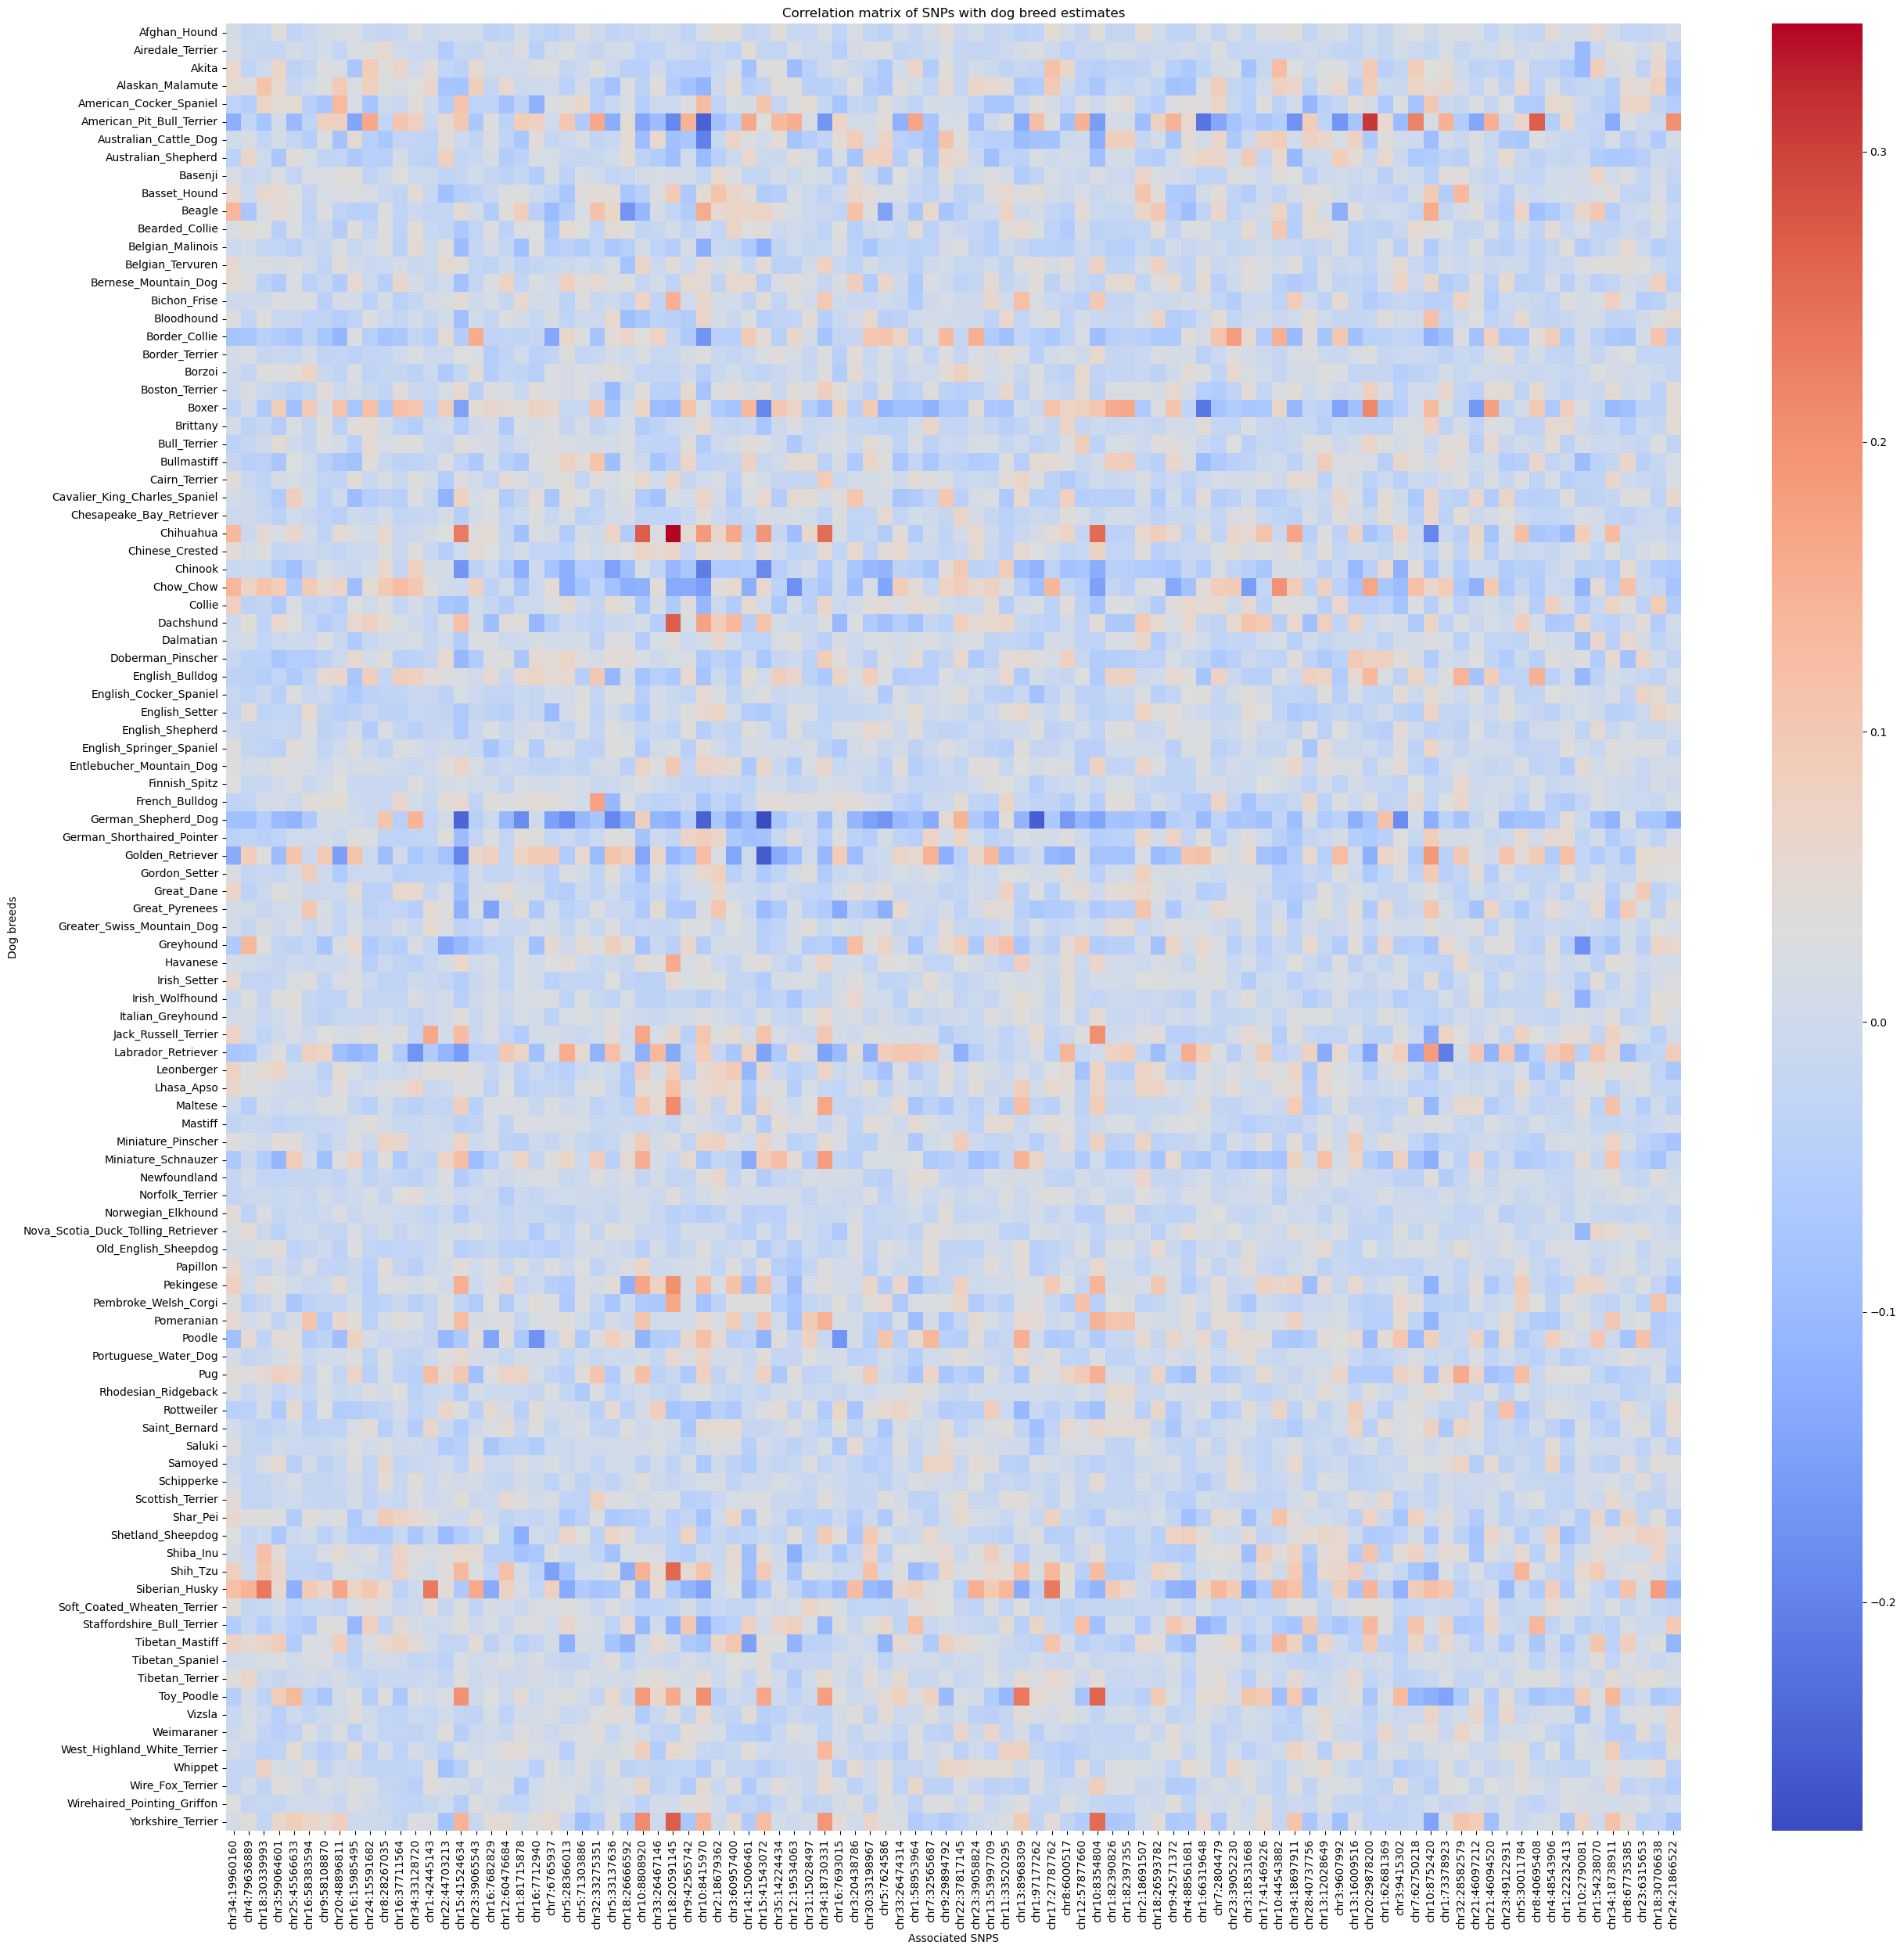

In [24]:
plt.figure(figsize=(30,30))

sns.heatmap(snp_corrs, annot = False, cmap='coolwarm')
plt.title("Correlation matrix of SNPs with dog breed estimates")
plt.xlabel("Associated SNPS")
plt.ylabel("Dog breeds")
plt.savefig("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/snp_correlation_with_breed.png", dpi=300)

In [25]:
top_five_breeds = {}
for snp in all_sites:
    top_five_breeds[snp] = list(snp_corrs.sort_values(snp,key=abs,ascending=False).index[:5])

# Add in breed estimates

In [26]:
ancestry_list = ["Labrador_Retriever", "Golden_Retriever", "German_Shepherd_Dog", "Yorkshire_Terrier", "Chihuahua"]
morphology_anc_all = run_likelihood_tests(marker_to_morphology, merge2, ancestry_dict =top_five_breeds)
behavior_anc_all = run_likelihood_tests(marker_to_behavior, merge2, ancestry_dict =top_five_breeds)

morphology_anc_mixed = run_likelihood_tests(marker_to_morphology, mixed, ancestry_dict =top_five_breeds)
behavior_anc_mixed = run_likelihood_tests(marker_to_behavior, mixed, ancestry_dict =top_five_breeds)

Running snp chr1:42445143, pheno 246
Running snp chr34:18730331, pheno 121
Running snp chr10:8354804, pheno 121
Running snp chr10:8354804, pheno 125
Running snp chr10:8415970, pheno 125
Running snp chr10:8415970, pheno 121
Running snp chr10:8752420, pheno 125
Running snp chr10:8752420, pheno 121
Running snp chr10:8808920, pheno 125
Running snp chr10:8808920, pheno 121
Running snp chr10:2790081, pheno 121
Running snp chr10:2790081, pheno 125
Running snp chr15:41543072, pheno 121
Running snp chr18:20591145, pheno 121
Running snp chr18:20591145, pheno 246
Running snp chr32:33275351, pheno 127
Running snp chr1:42445143, pheno 2
Running snp chr1:42445143, pheno 4
Running snp chr1:42445143, pheno 5
Running snp chr1:42445143, pheno 6
Running snp chr1:42445143, pheno 8
Running snp chr1:42445143, pheno 11
Running snp chr1:42445143, pheno 13
Running snp chr1:42445143, pheno 108
Running snp chr1:42445143, pheno 228
Running snp chr1:42445143, pheno factor_2
Running snp chr10:8354804, pheno 41
Runn

Running snp chr16:15985495, pheno 77
Running snp chr16:15985495, pheno factor_6
Running snp chr23:6315653, pheno 74
Running snp chr23:6315653, pheno 75
Running snp chr23:6315653, pheno 77
Running snp chr23:6315653, pheno factor_6
Running snp chr34:18738911, pheno 74
Running snp chr34:18738911, pheno 75
Running snp chr34:18738911, pheno 77
Running snp chr34:18738911, pheno factor_6
Running snp chr4:48543906, pheno 74
Running snp chr4:48543906, pheno 75
Running snp chr4:48543906, pheno 77
Running snp chr4:48543906, pheno factor_6
Running snp chr7:6765937, pheno 74
Running snp chr7:6765937, pheno 75
Running snp chr7:6765937, pheno 77
Running snp chr7:6765937, pheno factor_6
Running snp chr8:28267035, pheno 74
Running snp chr8:28267035, pheno 75
Running snp chr8:28267035, pheno 77
Running snp chr8:28267035, pheno factor_6
Running snp chr1:73378923, pheno 81
Running snp chr1:73378923, pheno 84
Running snp chr1:73378923, pheno 86
Running snp chr1:73378923, pheno 90
Running snp chr25:45566633

Running snp chr3:18531668, pheno 57
Running snp chr3:18531668, pheno factor_4
Running snp chr3:59064601, pheno 21
Running snp chr3:59064601, pheno 23
Running snp chr3:59064601, pheno 31
Running snp chr3:59064601, pheno 34
Running snp chr3:59064601, pheno 53
Running snp chr3:59064601, pheno 57
Running snp chr3:59064601, pheno factor_4
Running snp chr32:28582579, pheno 21
Running snp chr32:28582579, pheno 23
Running snp chr32:28582579, pheno 31
Running snp chr32:28582579, pheno 34
Running snp chr32:28582579, pheno 53
Running snp chr32:28582579, pheno 57
Running snp chr32:28582579, pheno factor_4
Running snp chr32:33275351, pheno 21
Running snp chr32:33275351, pheno 23
Running snp chr32:33275351, pheno 31
Running snp chr32:33275351, pheno 34
Running snp chr32:33275351, pheno 53
Running snp chr32:33275351, pheno 57
Running snp chr32:33275351, pheno factor_4
Running snp chr4:88561681, pheno 21
Running snp chr4:88561681, pheno 23
Running snp chr4:88561681, pheno 31
Running snp chr4:88561681,

Running snp chr16:37711564, pheno 71
Running snp chr16:37711564, pheno 73
Running snp chr16:37711564, pheno 75
Running snp chr16:37711564, pheno factor_6
Running snp chr20:29878200, pheno 71
Running snp chr20:29878200, pheno 73
Running snp chr20:29878200, pheno 75
Running snp chr20:29878200, pheno factor_6
Running snp chr24:15591682, pheno 71
Running snp chr24:15591682, pheno 73
Running snp chr24:15591682, pheno 75
Running snp chr24:15591682, pheno factor_6
Running snp chr35:14224434, pheno 71
Running snp chr35:14224434, pheno 73
Running snp chr35:14224434, pheno 75
Running snp chr35:14224434, pheno factor_6
Running snp chr5:33137636, pheno 71
Running snp chr5:33137636, pheno 73
Running snp chr5:33137636, pheno 75
Running snp chr5:33137636, pheno factor_6
Running snp chr7:32565687, pheno 71
Running snp chr7:32565687, pheno 73
Running snp chr7:32565687, pheno 75
Running snp chr7:32565687, pheno factor_6
Running snp chr1:58953964, pheno 74
Running snp chr1:58953964, pheno 75
Running snp 

Running snp chr11:33520295, pheno 31
Running snp chr11:33520295, pheno 34
Running snp chr11:33520295, pheno 53
Running snp chr11:33520295, pheno 57
Running snp chr11:33520295, pheno factor_4
Running snp chr12:60476684, pheno 21
Running snp chr12:60476684, pheno 23
Running snp chr12:60476684, pheno 31
Running snp chr12:60476684, pheno 34
Running snp chr12:60476684, pheno 53
Running snp chr12:60476684, pheno 57
Running snp chr12:60476684, pheno factor_4
Running snp chr2:18679362, pheno 21
Running snp chr2:18679362, pheno 23
Running snp chr2:18679362, pheno 31
Running snp chr2:18679362, pheno 34
Running snp chr2:18679362, pheno 53
Running snp chr2:18679362, pheno 57
Running snp chr2:18679362, pheno factor_4
Running snp chr2:18691507, pheno 21
Running snp chr2:18691507, pheno 23
Running snp chr2:18691507, pheno 31
Running snp chr2:18691507, pheno 34
Running snp chr2:18691507, pheno 53
Running snp chr2:18691507, pheno 57
Running snp chr2:18691507, pheno factor_4
Running snp chr3:18531668, p

In [27]:
all_results = morphology_results_all + behavior_results_all  + morphology_no_size_all + behavior_no_size_all + \
            morphology_results_mixed + behavior_results_mixed + morphology_no_size_mixed + behavior_no_size_mixed +\
            morphology_anc_all + behavior_anc_all + morphology_anc_mixed + behavior_anc_mixed


results  = pd.DataFrame(all_results).pivot(index = ['locus', 'pheno'], columns = 'model', values = 'LRT p-value')
results

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
questions_file = "/seq/vgb/bryc/data/darwins_dogs/2024-09-23_cache/questions.csv"
quest = pd.read_csv(questions_file)
id_to_string = dict(zip(quest.id.astype(str), quest.string))
results = results.reset_index()
results['question'] = results.pheno.map(id_to_string)

In [ ]:
results.to_csv("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/all_prediction_pvalues_top_ancs.csv", index=False)

# Make dataframe of p-values from various GWAS runs at these target sites:

In [93]:
stacked = pd.read_csv("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/target_SNPs_GWAS_associations.txt",
                      sep="\t",
                      header=None,
                      names = ["Chr", "SNP", "bp", "A1", "A2", "Freq", "b", "se", "p"])
stacked[["GWAS","Sep", "Chr"]] = stacked["Chr"].str.rpartition(".loco.mlma:",  expand = True)
stacked["GWAS"] = stacked["GWAS"].str.replace("/seq/vgb/vsohrab/darwins_dogs/pnas_behavior_morphology_gwas/association/","")

In [96]:
df = stacked.pivot(index = ['SNP'], columns = 'GWAS', values = 'p')
df.to_csv("/seq/vgb/bryc/data/darwins_dogs/pnas_dog_behavior_paper/results/target_SNP_GWAS_pvalues.csv")